In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sys
sys.path.append("..")
from src.dataset import SIModel
from src.approx_bc import abc_rejection_sampler
import seaborn as sns
from scipy.stats import norm, lognorm, multivariate_normal
from src.utils import lognormal_sd, get_results

In [97]:
sns.set_theme()
sns.set_style("white")
sns.set_palette("deep")
run_abc = True

beta_true = [0.05, .02, .04, .06, .08, .1, .05]
alpha = 0.1
gamma = 0.05
heterogeneous = True
N = 300 # consider increasing
T = 52
K = 30
data_seed = 31
prior_mu = [-3, -3, -3, -3, -3, -3, -3]
prior_sigma = [1, 1, 1, 1, 1, 1, 1]

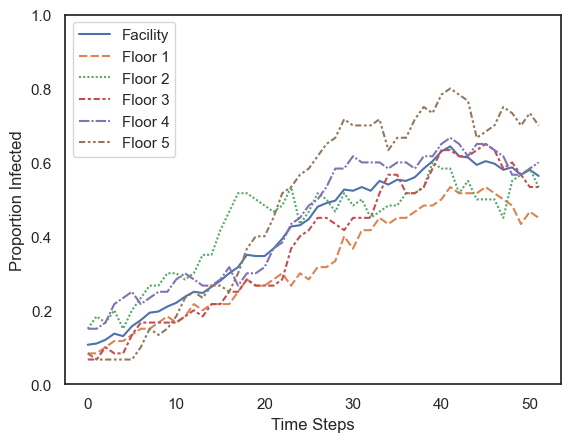

In [98]:
si_model = SIModel(alpha, gamma, beta_true, 
                    heterogeneous, prior_mu, prior_sigma,
                   N, T, summarize=False, flatten=False,
                  observed_seed=data_seed)
x_o = si_model.get_observed_data()

data = x_o[:6,:]

data = pd.DataFrame(data = data.T, columns=["Facility"] + [f"Floor {i}" for i in range(1,6)])

sns.lineplot(data)
plt.ylim((0,1))
plt.xlabel("Time Steps")
plt.ylabel("Proportion Infected")
plt.savefig("images/hetero_infection_viz.png")
plt.show()

# Likelihood-based

In [4]:
exact_sample = np.load("posterior_sample.npy")

In [5]:
exact_rates = np.exp(exact_sample).mean(0)
exact_means = exact_sample.mean(0)
exact_sds = exact_sample.std(0)

In [6]:
exact_rates

array([0.04904934, 0.02095275, 0.0631197 , 0.04323717, 0.06079229,
       0.10711736, 0.04647326])

In [7]:
np.exp(exact_sample).std(0)

array([0.01320814, 0.01351298, 0.019779  , 0.01834066, 0.02231105,
       0.0242641 , 0.01076369])

In [8]:
# ax = sns.pairplot(pd.DataFrame(np.exp(exact_sample), columns = [rf"$\beta_{k}$" for k in range(7)]))
# plt.savefig("images/pairsplot.png")

# NPE

In [9]:
df_npe = pd.read_csv("df_het.csv")
df_npe["mu"] = df_npe["mu"].apply(eval)
df_npe["sigma"] = df_npe["sigma"].apply(eval)

In [10]:
sigma = np.array(df_npe.iloc[-1]["sigma"])

In [11]:
df_npe_full = df_npe[df_npe["mean_field"] == False]
npe_means = np.array([r for r in df_npe_full["mu"]])
npe_sds = np.array([[r[i][i]**.5 for i in range(7)] for r in df_npe_full["sigma"]])

In [12]:
df_mf = df_npe[df_npe["mean_field"] == True]
mf_means = np.array([r for r in df_mf["mu"]])
mf_sds = np.array([[r[i][i]**.5 for i in range(7)] for r in df_mf["sigma"]])

In [171]:
df_ln = get_results("../multirun/2024-11-14/14-50-37").\
    sort_values(["n_sample", "val_loss"]).drop_duplicates("n_sample")
ln_means = np.array([r[0] for r in df_ln["mu"]])
ln_sds = np.array([[r[i][i]**.5 for i in range(7)] for r in df_ln["sigma"]])
ln_rates = np.exp(ln_means + ln_sds**2/2)

In [172]:
df_ln

,N,_target_,batch_size,d_model,dropout,lr,mean_field,mu,n_sample,prior_mu,prior_sigma,seed,sigma,val_loss,weight_decay
17,300,src.model.GaussianDensityNetwork,None,48,0.0,0.001,False,"[[-3.367050886154175, -3.6008944511413574, -3....",250,"[-3, -3, -3, -3, -3, -3, -3]","[1, 1, 1, 1, 1, 1, 1]",31,"[[0.6071063280105591, -0.0695190355181694, -0....",8.610700,0.01
9,300,src.model.GaussianDensityNetwork,None,48,0.0,0.001,False,"[[-3.1665565967559814, -3.689725637435913, -3....",500,"[-3, -3, -3, -3, -3, -3, -3]","[1, 1, 1, 1, 1, 1, 1]",31,"[[0.38217729330062866, -0.11673129349946976, -...",7.592714,0.02
5,300,src.model.GaussianDensityNetwork,None,48,0.0,0.001,False,"[[-3.2294058799743652, -4.058983325958252, -3....",1000,"[-3, -3, -3, -3, -3, -3, -3]","[1, 1, 1, 1, 1, 1, 1]",31,"[[0.3433685898780823, -0.0668453499674797, 0.0...",6.477123,0.00
0,300,src.model.GaussianDensityNetwork,None,56,0.0,0.001,False,"[[-2.9767091274261475, -4.031996726989746, -3....",2000,"[-3, -3, -3, -3, -3, -3, -3]","[1, 1, 1, 1, 1, 1, 1]",31,"[[0.1324537992477417, -0.08396133035421371, -0...",6.031549,0.02
31,300,src.model.GaussianDensityNetwork,None,56,0.0,0.001,False,"[[-2.959850788116455, -4.027965545654297, -3.2...",4000,"[-3, -3, -3, -3, -3, -3, -3]","[1, 1, 1, 1, 1, 1, 1]",31,"[[0.11475963890552521, -0.05386042222380638, -...",5.703513,0.02


## Posterior Predictive Checks

In [13]:
mu = df_npe["mu"].iloc[-1]
sigma = df_npe["sigma"].iloc[-1]
neural_posterior = multivariate_normal(mu, sigma)
K = 30
npe_sample = np.empty((0,7))
seed = 2
while npe_sample.shape[0] < K:
    draw = neural_posterior.rvs(size=K, random_state=seed)
    seed += 1
    accepted = draw[(draw > 0).all(axis=1)]
    npe_sample = np.concatenate((npe_sample, accepted), axis=0)
npe_sample = npe_sample[:K]

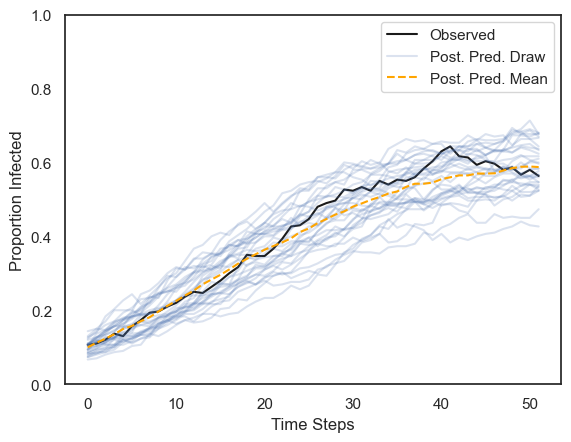

In [140]:
posterior_predictive = np.empty((K, 7, T))
j = 0
si_model = SIModel(alpha, gamma, beta_true, 
                   heterogeneous, prior_mu, prior_sigma, 
                   N, T, summarize=False, observed_seed=31,
                   flatten=False)
x_o = si_model.get_observed_data()

for i in range(K):
    si_model = SIModel(alpha, gamma, np.clip(npe_sample[i], 1e-8, None), 
                   heterogeneous, prior_mu, prior_sigma,
                   N, T, summarize=False, flatten=False)
    x_rep = si_model.get_observed_data(i)
    posterior_predictive[i] =  np.array(x_rep)
pp_mean = posterior_predictive.mean(0)[j]

labels = ["Post. Pred. Draw"] + [None for _ in range(K-1)]
I_o = np.array(x_o)[j]
plt.plot(I_o, label="Observed", color="k")
plt.plot(posterior_predictive[:,j,:].T, 
         label=labels, color="b",
         alpha=0.2)
plt.plot(pp_mean, label="Post. Pred. Mean", linestyle="--",
         color="orange")
plt.legend()
plt.ylabel("Proportion Infected")
plt.xlabel("Time Steps")
plt.savefig("images/ppc_het.png")
plt.ylim(0, 1)
plt.show()

#### stupid ppc

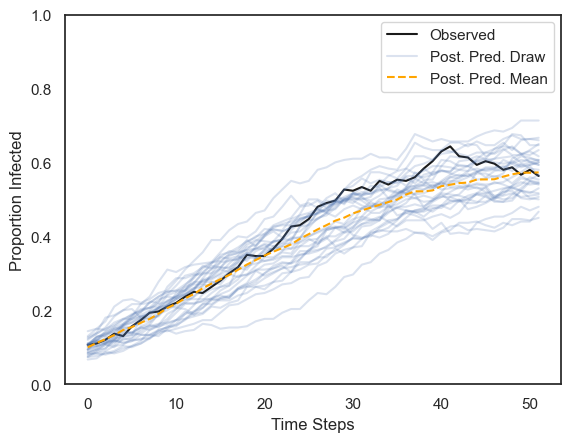

In [173]:
mu2 = df_ln.iloc[-1]["mu"][0]
sigma2 = df_ln.iloc[-1]["sigma"]
neural_posterior2 = multivariate_normal(mu2, sigma2)
npe_sample2 = np.exp(neural_posterior2.rvs(size=K, random_state=seed))
posterior_predictive = np.empty((K, 7, T))
j = 0
si_model = SIModel(alpha, gamma, beta_true, 
                   heterogeneous, prior_mu, prior_sigma, 
                   N, T, summarize=False, observed_seed=31,
                   flatten=False)
x_o = si_model.get_observed_data()

for i in range(K):
    si_model = SIModel(alpha, gamma, np.clip(npe_sample2[i], 1e-8, None), 
                   heterogeneous, prior_mu, prior_sigma,
                   N, T, summarize=False, flatten=False)
    x_rep = si_model.get_observed_data(i)
    posterior_predictive[i] =  np.array(x_rep)
pp_mean = posterior_predictive.mean(0)[j]

labels = ["Post. Pred. Draw"] + [None for _ in range(K-1)]
I_o = np.array(x_o)[j]
plt.plot(I_o, label="Observed", color="k")
plt.plot(posterior_predictive[:,j,:].T, 
         label=labels, color="b",
         alpha=0.2)
plt.plot(pp_mean, label="Post. Pred. Mean", linestyle="--",
         color="orange")
plt.legend()
plt.ylabel("Proportion Infected")
plt.xlabel("Time Steps")
# plt.savefig("images/ppc_het.png")
plt.ylim(0, 1)
plt.show()

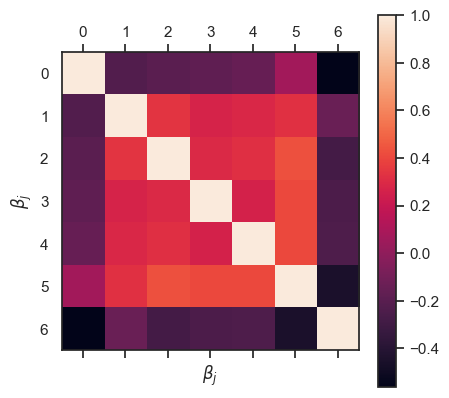

In [174]:
D = np.diag(1 / np.sqrt(np.diag(sigma2)))
corr = D @ sigma2 @ D
plt.matshow(corr, cmap="rocket")
plt.colorbar()
plt.xlabel(r"$\beta_j$")
plt.ylabel(r"$\beta_j$")
# plt.savefig("images/corr.png")
plt.show()

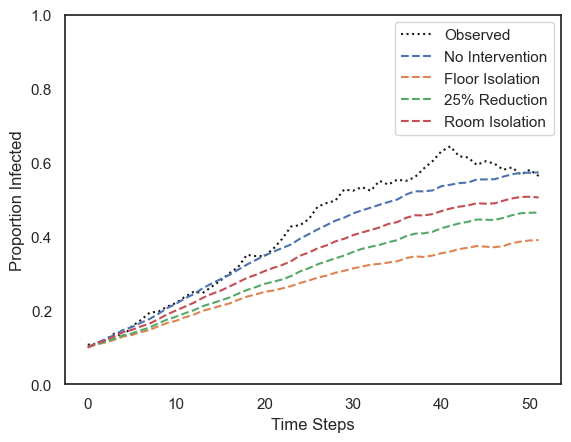

In [199]:
pis = [
    [.1, 1, 1, 1, 1, 1, 1],
    [.75, .75, .75, .75, .75, .75, .75],
    [1, 1, 1, 1, 1, 1, 1e-8]
]
intervention = np.empty((K, len(pis), T))
# fix this: truncate...
for j, pi in enumerate(pis):
    for i in range(K):
        si_model = SIModel(alpha, gamma, npe_sample[i], 
                    heterogeneous, prior_mu, prior_sigma,
                    N, T, summarize=False, flatten=False,
                    pi=pi)
        x_rep = si_model.get_observed_data(i)
        intervention[i,j] =  np.array(x_rep)[0]
intervention = intervention.mean(0)

plt.plot(I_o, label="Observed", color="k", linestyle=":")
plt.plot(pp_mean, label="No Intervention", linestyle="--")
plt.plot(intervention[0], label="Floor Isolation", linestyle="--")
plt.plot(intervention[1], label="25% Reduction", linestyle="--")
plt.plot(intervention[2], label="Room Isolation", linestyle="--")
# plt.plot(intervention[3], label="?", linestyle=":")
plt.legend()
plt.ylim(0, 1)
plt.xlabel("Time Steps")
plt.ylabel("Proportion Infected")
plt.savefig("images/intervention.png")


## ABC

In [20]:
summarize = False
if run_abc:
    n_simulations = []
    abc_samples = []
    epsilons = [2.8, 2.5, 2.3, 2.1, 1.9, 1.8, 1.75]
    for epsilon in epsilons:
        si_model = SIModel(alpha, gamma, beta_true, 
                        heterogeneous, prior_mu, prior_sigma, 
                       N, T, summarize, observed_seed=31, flatten=False)
        prior_sampler = lambda: si_model.sample_logbeta(1)
        simulator = lambda theta, seed: si_model.SI_simulator(theta, seed)
        x_o = si_model.get_observed_data()
        S = 100
        print(f"epsilon: {epsilon}")
        posterior_sample, errors = abc_rejection_sampler(
            S, epsilon, prior_sampler, simulator, x_o, max_attempts=40000,
            summarize=False
            )
        print("***")
        n_simulations.append((errors > 0).sum())
        abc_samples.append(posterior_sample)   

epsilon: 2.8
Time lapsed: 7.00 seconds
With tolerance 2.8, acceptance rate: 0.242718
Total number of attempts: 412
***
epsilon: 2.5
Time lapsed: 11.16 seconds
With tolerance 2.5, acceptance rate: 0.149701
Total number of attempts: 668
***
epsilon: 2.3
Time lapsed: 16.88 seconds
With tolerance 2.3, acceptance rate: 0.098814
Total number of attempts: 1,012
***
epsilon: 2.1
Time lapsed: 30.51 seconds
With tolerance 2.1, acceptance rate: 0.054496
Total number of attempts: 1,835
***
epsilon: 1.9
Time lapsed: 62.91 seconds
With tolerance 1.9, acceptance rate: 0.026617
Total number of attempts: 3,757
***
epsilon: 1.8
Attempts: 5,000
Time lapsed: 87.48 seconds
With tolerance 1.8, acceptance rate: 0.019635
Total number of attempts: 5,093
***
epsilon: 1.75
Attempts: 5,000
Time lapsed: 133.35 seconds
With tolerance 1.75, acceptance rate: 0.013079
Total number of attempts: 7,646
***


In [21]:
abc_posterior = np.array(abc_samples)
np.save("abc_results", abc_posterior)

# Approximation Error

In [211]:
original_pal = sns.color_palette('deep')
new_pal = original_pal[:2] + original_pal[3:]
sns.set_palette(new_pal)

### Total Square Error

In [175]:
npe_sims = list(df_npe_full["n_sample"].values)

data = {"Method": ["NPE"]*5 + ["ABC"]*7 + ["NPE-MF"]*5 + ["NPE-LN"]*5,
        "Simulations": npe_sims + n_simulations + npe_sims + npe_sims,
        "Error": np.concatenate(
            [((npe_means - exact_rates)**2).sum(1),
             ((np.exp(abc_posterior).mean(1) - exact_rates)**2).sum(1),
             ((mf_means - exact_rates)**2).sum(1),
             ((ln_rates - exact_rates)**2).sum(1),
            ]
        )
}
mean_mse = pd.DataFrame(data)

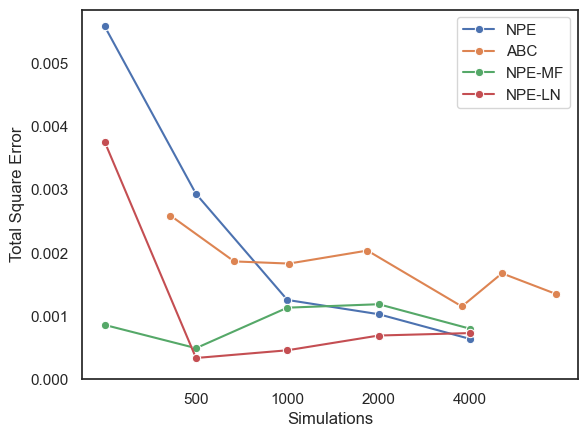

In [209]:
ax = sns.lineplot(mean_mse, x="Simulations", y="Error", hue="Method", marker="o")
plt.xscale("log")
plt.xlabel("Simulations")
plt.ylabel("Total Square Error")
plt.legend(title=None)
plt.ylim(0, None)
ax.set_xticks([500, 1000, 2000, 4000])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
# plt.savefig("images/het-error-ln.png")
plt.show()

In [42]:
def get_errors(j):
    data = {"Method": ["NPE"]*5 + ["ABC"]*7 + ["NPE-MF"]*5,
        "Simulations": npe_sims + n_simulations + npe_sims,
        "Error": np.concatenate(
            [npe_means[:, j],
             np.exp(abc_posterior).mean(1)[:, j],
             mf_means[:, j]
            ]
        )
    }
    return pd.DataFrame(data)

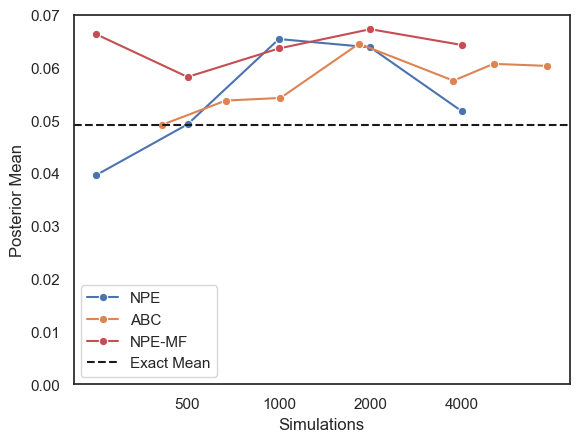

In [43]:
beta_0 = get_errors(0)
ax = sns.lineplot(beta_0, x="Simulations", y="Error", hue="Method", marker="o")
plt.xscale("log")
plt.xlabel("Simulations")
plt.axhline(y = exact_rates[0], color="k", label=r"Exact Mean", linestyle="--")
plt.ylabel("Posterior Mean")
plt.legend(title=None)
ax.set_xticks([500, 1000, 2000, 4000])
plt.ylim(0, 0.07)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.savefig("images/het-error-b.png")
plt.show()

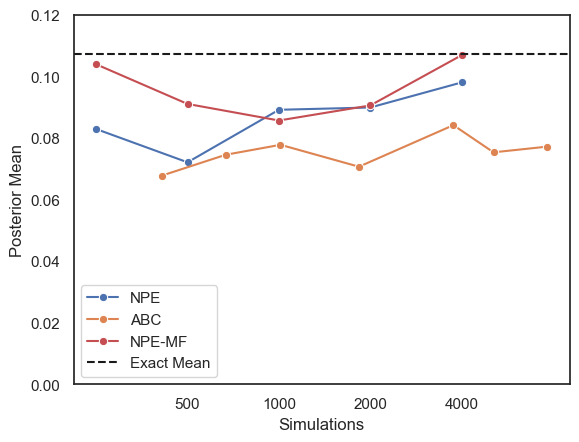

In [44]:
beta_0 = get_errors(5)
ax = sns.lineplot(beta_0, x="Simulations", y="Error", hue="Method", marker="o")
plt.xscale("log")
plt.xlabel("Simulations")
plt.axhline(y = exact_rates[5], color="k", label=r"Exact Mean", linestyle="--")
plt.ylabel("Posterior Mean")
plt.legend(title=None)
ax.set_xticks([500, 1000, 2000, 4000])
plt.ylim(0, 0.12)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.savefig("images/het-error-c.png")
plt.show()

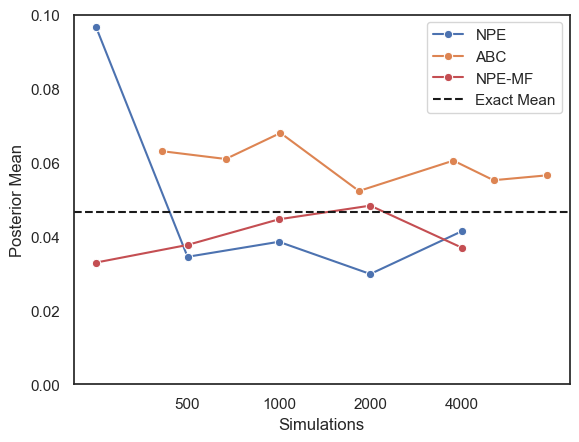

In [47]:
beta_0 = get_errors(6)
ax = sns.lineplot(beta_0, x="Simulations", y="Error", hue="Method", marker="o")
plt.xscale("log")
plt.xlabel("Simulations")
plt.axhline(y = exact_rates[6], color="k", label=r"Exact Mean", linestyle="--")
plt.ylabel("Posterior Mean")
plt.legend(title=None)
ax.set_xticks([500, 1000, 2000, 4000])
plt.ylim(0, .10)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.savefig("images/het-error-d.png")
plt.show()

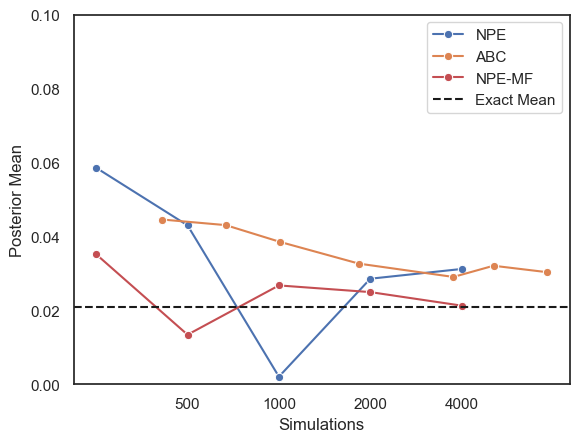

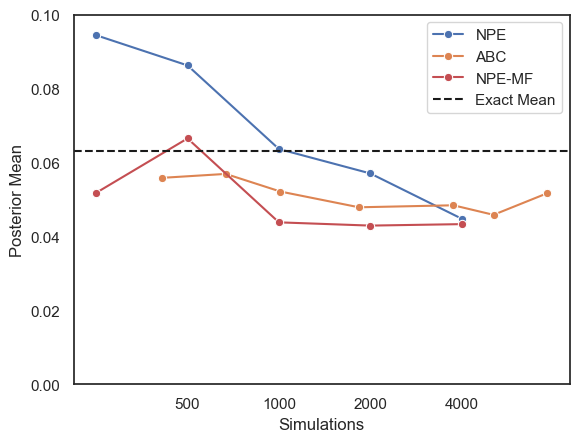

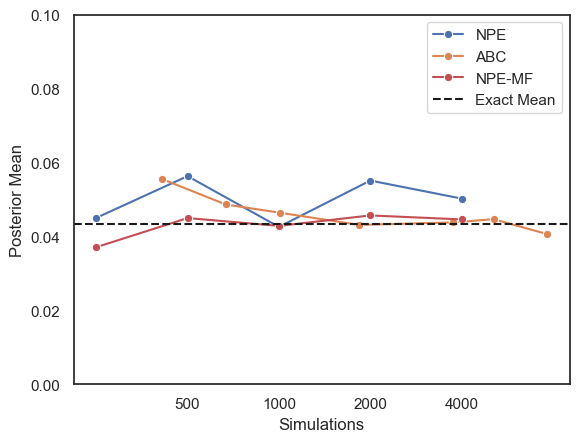

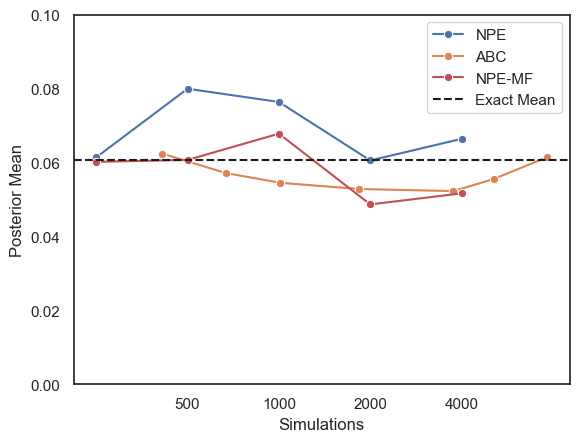

In [212]:
for j in [1, 2, 3, 4]:
    beta_j = get_errors(j)
    ax = sns.lineplot(beta_j, x="Simulations", y="Error", hue="Method", marker="o")
    plt.xscale("log")
    plt.xlabel("Simulations")
    plt.axhline(y = exact_rates[j], color="k", label=r"Exact Mean", linestyle="--")
    plt.ylabel("Posterior Mean")
    plt.legend(title=None)
    ax.set_xticks([500, 1000, 2000, 4000])
    plt.ylim(0, .10)
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    plt.savefig(f"images/het-error-misc-{j}.png")
    plt.show()

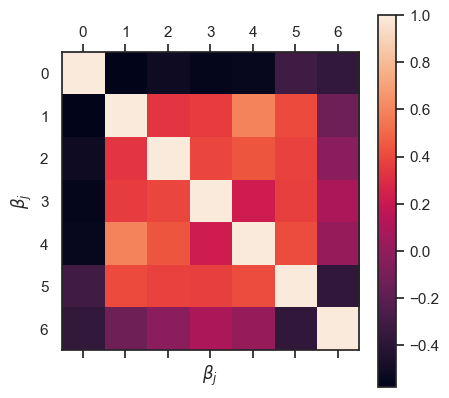

In [401]:
D = np.diag(1 / np.sqrt(np.diag(sigma)))
corr = D @ sigma @ D
plt.matshow(corr, cmap="rocket")
plt.colorbar()
plt.xlabel(r"$\beta_j$")
plt.ylabel(r"$\beta_j$")
plt.savefig("images/corr.png")
plt.show()

### Master Table

In [245]:
exact_rates

array([0.04904934, 0.02095275, 0.0631197 , 0.04323717, 0.06079229,
       0.10711736, 0.04647326])

In [48]:
n_simulations

[412, 668, 1012, 1835, 3757, 5093, 7646]

In [163]:
het_table = pd.DataFrame({
    "Transmission Rate": ["Facility"] + [f"Floor {i}" for i in range(1, 6)] + ["Room"],
    "Value": [0.05, 0.02, 0.04, 0.06, 0.08, 0.1, 0.05],
    "Exact": exact_rates,
    "NPE": npe_means[-1],
    "ABC": np.exp(abc_posterior[-1]).mean(0)
})

In [162]:
het_table2 = pd.DataFrame({
    "Transmission Rate": ["Facility"] + [f"Floor {i}" for i in range(1, 6)] + ["Room"],
    "Value": [0.05, 0.02, 0.04, 0.06, 0.08, 0.1, 0.05],
    "Exact": np.exp(exact_sample).std(0),
    "NPE": np.diag(sigma)**0.5,
    "ABC": np.exp(abc_posterior[-1]).std(0)
})

In [166]:
np.log(0.107)

-2.234926444520231

In [204]:
np.arange(1, step=1/8)

array([0.   , 0.125, 0.25 , 0.375, 0.5  , 0.625, 0.75 , 0.875])

In [170]:
norm(-3, 1).cdf(-2.23)

0.7793500536573503

In [53]:
# 4000 vs 7,646 simulations, ABC vs NPE
print(het_table.to_latex())

\begin{tabular}{llrrrr}
\toprule
 & Transmission Rate & Value & Exact & NPE & ABC \\
\midrule
0 & Facility & 0.050000 & 0.049049 & 0.051728 & 0.060292 \\
1 & Floor 1 & 0.020000 & 0.020953 & 0.031189 & 0.030322 \\
2 & Floor 2 & 0.040000 & 0.063120 & 0.044793 & 0.051665 \\
3 & Floor 3 & 0.060000 & 0.043237 & 0.050232 & 0.040634 \\
4 & Floor 4 & 0.080000 & 0.060792 & 0.066404 & 0.061409 \\
5 & Floor 5 & 0.100000 & 0.107117 & 0.097992 & 0.077147 \\
6 & Room & 0.050000 & 0.046473 & 0.041380 & 0.056529 \\
\bottomrule
\end{tabular}



In [164]:
print(het_table2.to_latex())

\begin{tabular}{llrrrr}
\toprule
 & Transmission Rate & Value & Exact & NPE & ABC \\
\midrule
0 & Facility & 0.050000 & 0.013208 & 0.016248 & 0.021481 \\
1 & Floor 1 & 0.020000 & 0.013513 & 0.022609 & 0.022045 \\
2 & Floor 2 & 0.040000 & 0.019779 & 0.024013 & 0.033280 \\
3 & Floor 3 & 0.060000 & 0.018341 & 0.023678 & 0.023380 \\
4 & Floor 4 & 0.080000 & 0.022311 & 0.027285 & 0.032088 \\
5 & Floor 5 & 0.100000 & 0.024264 & 0.027565 & 0.042606 \\
6 & Room & 0.050000 & 0.010764 & 0.023463 & 0.045166 \\
\bottomrule
\end{tabular}



### Credible Intervals

In [54]:
exact_cis = list(zip(
    np.quantile(np.exp(exact_sample), 0.05, axis=0),
    np.quantile(np.exp(exact_sample), 0.95, axis=0),
))

In [63]:
exact_cis

[(0.024011465950142297, 0.06801962761066291),
 (0.004932044672989692, 0.04239226318700416),
 (0.032651160993738985, 0.09279989559704233),
 (0.016547622243718495, 0.07317029413681488),
 (0.02847195564504082, 0.09823522142803313),
 (0.07092659857649762, 0.14826577490881668),
 (0.028361788600573777, 0.06209574957661984)]

In [59]:
m = npe_means[-1]
s = npe_sds[-1]

npe_cis = [(norm(m[j], s[j]).ppf(0.05),
              norm(m[j], s[j]).ppf(0.95)) for j in range(7)]

In [60]:
npe_cis

[(0.025002874000509556, 0.07845399572090309),
 (-0.00599994105538823, 0.06837814641437029),
 (0.005295637563051826, 0.084289815708814),
 (0.011284197367258116, 0.08917905887263292),
 (0.021524186976110804, 0.1112831572221161),
 (0.05265196350891393, 0.1433320573202868),
 (0.0027872496065251204, 0.07997324087055997)]

In [61]:
abc_cis = list(zip(
    np.quantile(np.exp(abc_posterior[-1]), 0.05, axis=0),
    np.quantile(np.exp(abc_posterior[-1]), 0.95, axis=0),
))

In [62]:
abc_cis

[(0.021018127910792828, 0.09428292959928512),
 (0.006390487751923501, 0.06923775523900985),
 (0.011798945255577564, 0.11941256374120711),
 (0.01168043022044003, 0.07727548629045486),
 (0.014166562352329493, 0.11564379520714282),
 (0.018331688642501832, 0.1520729586482048),
 (0.009789556125178933, 0.1522801175713539)]

In [101]:
round((3.1415))

3

In [102]:
het_cis = pd.DataFrame({
    "Transmission Rate": ["Facility"] + [f"Floor {i}" for i in range(1, 6)] + ["Room"],
    "Value": [0.05, 0.02, 0.04, 0.06, 0.08, 0.1, 0.05],
    "Exact": round(exact_cis, 5),
    "NPE": round(npe_cis, 5),
    "ABC": round(abc_cis, 5)
})
print(het_cis.to_latex())

TypeError: type list doesn't define __round__ method

### ABC

In [113]:
# sns.pairplot(pd.DataFrame(np.exp(abc_posterior[-1])))

## Model Identiafiability

In [84]:
df_ident = get_results("../multirun/2024-11-12/17-36-17").sort_values("val_loss")

In [91]:
ident_mu = np.array(df_ident["mu"][0][0])

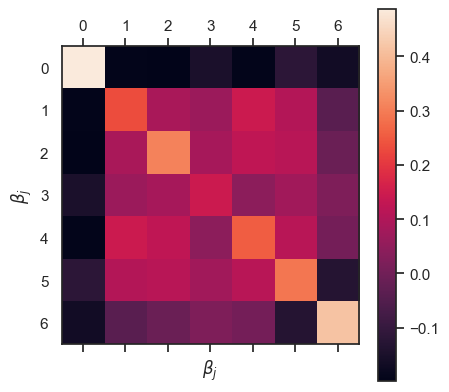

In [90]:
ident_sigma = np.array(df_ident["sigma"][0])
D = np.diag(1 / np.sqrt(np.diag(ident_sigma)))
corr = D @ sigma @ D
plt.matshow(corr, cmap="rocket")
plt.colorbar()
plt.xlabel(r"$\beta_j$")
plt.ylabel(r"$\beta_j$")
# plt.savefig("images/corr.png")
plt.show()

In [94]:
for i in range(7):
    dist = norm(ident_mu[i], ident_sigma[i][i]**0.5)
    print(dist.ppf(0.05), dist.ppf(0.95))

0.06471757846194659 0.14132298273724164
-0.031018670885393132 0.12336104014379687
-0.03677930363036777 0.10532144137241027
-0.06410498018782027 0.13999460484306694
-0.04054438630046099 0.13671520659627165
-0.04085645655950523 0.12754412571748708
-0.020472496642778608 0.09938881535739727


#### modified NPE estimates

In [205]:
neural_posterior = multivariate_normal(mu, sigma)
K = 100
npe_sample2 = np.empty((0,7))
seed = 2
while npe_sample2.shape[0] < K:
    draw = neural_posterior.rvs(size=K, random_state=seed)
    seed += 1
    accepted = draw[(draw > 0).all(axis=1)]
    npe_sample2 = np.concatenate((npe_sample2, accepted), axis=0)
npe_sample2 = npe_sample2[:K]

In [206]:
npe_sample2.mean(0)

array([0.04937507, 0.03721752, 0.04462206, 0.05377934, 0.06986681,
       0.09807904, 0.0417106 ])

In [208]:
exact_rates

array([0.04904934, 0.02095275, 0.0631197 , 0.04323717, 0.06079229,
       0.10711736, 0.04647326])